## Tips & tricks 3 : model with redundant components

In this model, we will have a load that can be provided by two identical competitive sources.

####  Base model

In [1]:
import math

import matplotlib.pyplot as plt
import pandas as pd

from eesrep import Eesrep
from eesrep.components.bus import GenericBus
from eesrep.components.sink_source import FatalSink, Source

In [2]:
model = Eesrep(interface="docplex")

unit_1 = Source(name="unit_1", p_min = 0., p_max = 100, price=100.)
unit_2 = Source(name="unit_2", p_min = 0., p_max = 100, price=100.)

fs_df = pd.DataFrame({"time": list(range(50)), 
                            "value": [150 for _ in range(50)]})

load = FatalSink(name="load", 
                        sink_flow = fs_df)

model.add_component(unit_1)
model.add_component(unit_2)
model.add_component(load)

bus = GenericBus("bus")
model.add_component(bus)
                        
model.plug_to_bus(io = unit_1.power_out, bus_io = bus.input, factor=1., offset=0.)
model.plug_to_bus(io = unit_2.power_out, bus_io = bus.input, factor=1., offset=0.)
model.plug_to_bus(io = load.power_in, bus_io = bus.output, factor=1., offset=0.)

model.define_time_range(time_step = 1., 
                        time_shift = 1, 
                        future_size = 50, 
                        horizon_count = 1)
                        
model.solve()

Running first time step


As we can see in the results below, both sources can be called anytime, eventually giving a chaotic behavior.

Total price : 735000.0.


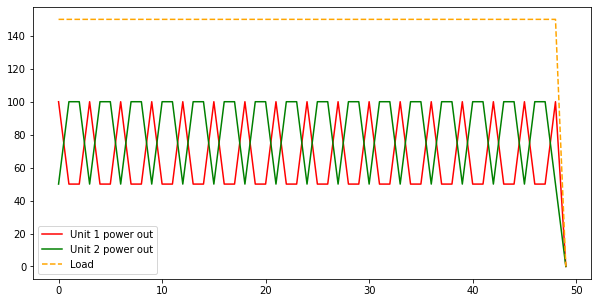

In [3]:
results = model.get_results(as_dataframe=False)

print(f"Total price : {sum(results['unit_1']['power_out']+results['unit_2']['power_out'])*100}.")

plt.figure(figsize=(10,5))
plt.plot(results["unit_1"]["power_out"], label = "Unit 1 power out", color="r")
plt.plot(results["unit_2"]["power_out"], label = "Unit 2 power out", color="g")
plt.plot(results["load"]["power_in"], label = "Load", linestyle = "dashed", color="orange")
plt.legend()
plt.show()

####  Tweaked model

The behavior showed above can be fixed by slightly changing the price of one of the means, the cheapest will be called first, and the second when the first is called at its maximum capacity.

In [4]:
model = Eesrep(interface="docplex")

unit_1 = Source(name="unit_1", p_min = 0., p_max = 100, price=100.)
unit_2 = Source(name="unit_2", p_min = 0., p_max = 100, price=100.0000001)

fs_df = pd.DataFrame({"time": list(range(50)), 
                            "value": [150 for _ in range(50)]})

load = FatalSink(name="load", 
                        sink_flow = fs_df)

model.add_component(unit_1)
model.add_component(unit_2)
model.add_component(load)

bus = GenericBus("bus")
model.add_component(bus)
                        
model.plug_to_bus(io = unit_1.power_out, bus_io = bus.input, factor=1., offset=0.)
model.plug_to_bus(io = unit_2.power_out, bus_io = bus.input, factor=1., offset=0.)
model.plug_to_bus(io = load.power_in, bus_io = bus.output, factor=1., offset=0.)

model.define_time_range(time_step = 1., 
                        time_shift = 1, 
                        future_size = 50, 
                        horizon_count = 1)
                        
model.solve()

Running first time step


We can see below that the expected behavior is now respected, with a negligible change of total price.

Total price : 735000.0002450002.


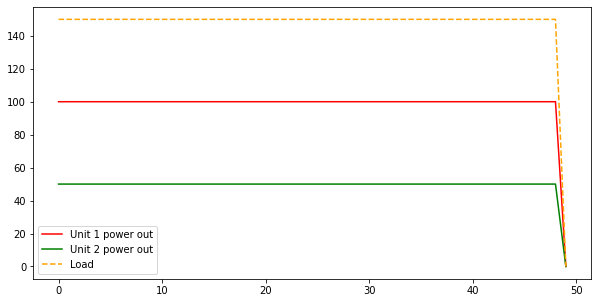

In [5]:
results = model.get_results(as_dataframe=False)

print(f"Total price : {sum(results['unit_1']['power_out']*100+results['unit_2']['power_out']*100.0000001)}.")

plt.figure(figsize=(10,5))
plt.plot(results["unit_1"]["power_out"], label = "Unit 1 power out", color="r")
plt.plot(results["unit_2"]["power_out"], label = "Unit 2 power out", color="g")
plt.plot(results["load"]["power_in"], label = "Load", linestyle = "dashed", color="orange")
plt.legend()
plt.show()